## Load packages

In [1]:
%matplotlib inline 
import rdflib, glob, pandas as pd
from rdflib.namespace import RDF, RDFS

## Define namespaces

In [2]:
abri = rdflib.Namespace("https://w3id.org/anything-but-routine/4.0/instance/")
abrw = rdflib.Namespace("https://w3id.org/anything-but-routine/4.0/work/")
bf = rdflib.Namespace("http://id.loc.gov/ontologies/bibframe/")
arm = rdflib.Namespace("https://w3id.org/arm/core/ontology/0.1/")

## Parse all .ttl files in subdirectories into a graph

In [3]:
def initialize_abr_graph():
    g = rdflib.Graph()
    g.bind("abri", "https://w3id.org/anything-but-routine/4.0/instance/")
    g.bind("abrw", "https://w3id.org/anything-but-routine/4.0/work/")
    g.bind("bf", "http://id.loc.gov/ontologies/bibframe/")
    g.bind("arm", "https://w3id.org/arm/core/ontology/0.1/")
    return g

In [13]:
g = initialize_abr_graph()
for infile in glob.glob("edited-ttl/*/*.ttl"):
    g.parse(infile, format='n3')
n = len(g)
print(f"ABR graph has {n} triples.")

ABR graph has 2795 triples.


## Walk the graph to display instances

In [14]:
qres = g.query(
    """SELECT ?i ?abrno
       WHERE {
          ?w rdf:type bf:Work .
          ?i bf:instanceOf ?w .
          ?i bf:provisionActivity ?a .
          ?i bf:identifiedBy ?id .
          ?id bf:source 'Schottlaender v4.0' .
          ?id rdf:value ?abrno .
       }
       ORDER BY ASC(?abrno)""")

for row in qres:
    instance = row[0]
    entry = ''
    ids = {}
    for id in g.objects(instance, bf.identifiedBy):
        ids['{}'.format(g.value(id, bf.source))] = '{}'.format(g.value(id, RDF.value))
    # Schottlaender no. + bf:title
    # titles can be more complex
    entry += '{}. {}. '.format(ids['Schottlaender v4.0'], g.value(g.value(instance, bf.title), RDFS.label))
    # bf:contributor
    for contributor in g.objects(instance, bf.contributor):
        agent = g.value(contributor, RDFS.label)
        # agents can have more than one role
        role = g.value(contributor, bf.role)
        entry += '{}, {}; '.format(agent, role)
    entry = "{}. ".format(entry[:-2])
    # bf:provisionActivity
    for publisher in g.objects(instance, bf.provisionActivity):
        # provisionActivities can more than one place
        place = g.value(publisher, bf.place)
        # provisionActivities can more than one agent
        agent = g.value(publisher, bf.agent)
        date = g.value(publisher, bf.date)
        entry += '{}: {}, {}; '.format(place, agent, date)
    entry = "{}. ".format(entry[:-2])
    # bf:copyrightDate
    if g.value(instance, bf.copyrightDate):
        entry += '©{}. '.format(g.value(instance, bf.copyrightDate))
    # M&M no. (if present)
    if 'Maynard & Miles' in ids:
        entry += '{' + 'M&M {}'.format(ids['Maynard & Miles']) + '}'
    print(entry)
    # bf.note
    for note in g.objects(instance, bf.note):
        print('    - {}'.format(g.value(note, RDF.value)))
    print('')

A10a. Nova Express. William S. Burroughs, author. New York: Grove Press, 1964. {M&M A10a}
    - Hardbound in dustjacket (no softbound issued).

A10b. Nova Express. William S. Burroughs, author. New York: Grove Press, 1965. {M&M A10b}
    - (An Evergreen Black Cat Book, BC-102)
    - 1st Evergreen Black Cat ed.
    - Softbound (no hardbound issued).

A10c. Nova Express. William S. Burroughs, author. London: Jonathan Cape, 1966. ©1964. {M&M A10c}
    - Hardbound in dustjacket (no softbound issued).

A10d. Nova Express. William S. Burroughs, author. London: Panther Books/Granada Publishing, 1968. {M&M A10d}
    - 1978 printing: title misspelled as Nova Expresss on title page.
    - Reprinted in 1969 and 1972 with different covers (per M&M), in 1978, and in 1982 (per Shoaf 1).
    - Softbound (no hardbound issued).
    - (Panther Science Fiction)

A10e. Nova Express. William S. Burroughs, author. New York: Grove Press, 1992. 
    - 1st Evergreen ed.

A10f. Nova Express: The Restored Text. 

## Query the graph to plot publications over year

### Query graph to get instance dates and express results as list of lists

In [15]:
qres = g.query(
    """SELECT DISTINCT ?i ?d
       WHERE {
          ?i rdf:type bf:Instance .
          ?i bf:provisionActivity ?a .
          ?a bf:date ?d .
       }""")

instance_dates = [ [row[0].toPython(), row[1].toPython() ] for row in qres ]

### Load instance dates into a dataframe and plot publications by year

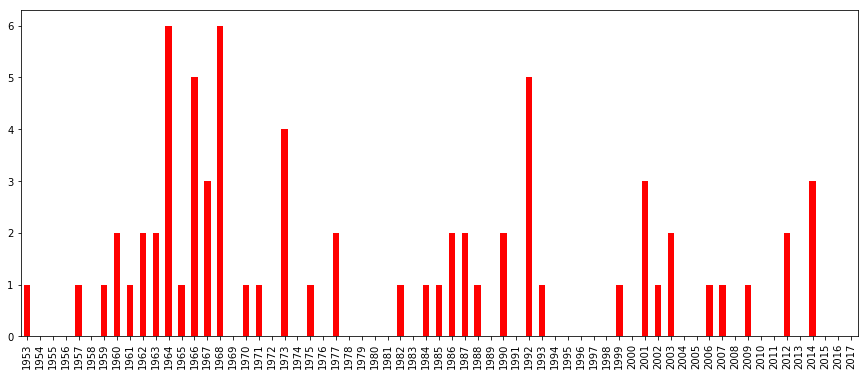

In [16]:
df = pd.DataFrame(instance_dates, columns=['instance', 'date'])
df['year'] = df['date'].str.extract('(\d\d\d\d)', expand=False)
pub_years = df['year'].value_counts().to_dict()
for year in range(1953, 2018):
    if '{}'.format(year) not in pub_years:
        pub_years['{}'.format(year)] = 0
pub_df = pd.DataFrame({'year': pub_years })
pub_df['year'].plot(kind='bar',figsize=[15, 6], color='red')